<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

In [65]:
batch_size = 32
num_epochs = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.28604, 0.35302)
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0.28604, 0.35302)
])

trainset = torchvision.datasets.FashionMNIST("/content/data", train=True, download=True, transform=train_transform)
testset = torchvision.datasets.FashionMNIST("/content/data", train=False, download=True, transform=test_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)


In [3]:
def get_mean_and_std(dataset, num_chans=3):
  #Default: dataset has shape (b, h, w, c)
  mean = np.zeros(3)
  std = np.zeros(3)
  for c in range(num_chans):
    chans = dataset.data[:, :, :, c]
    mean[c] = np.round(chans.mean() / 255, 5)
    for idx in range(chans.shape[0]):
      std[c] += np.std(chans[idx, :, :], ddof=1)
    std[c] /= len(dataset) * 255
    std[c] = round(std[c], 5)
  return list(mean), list(std)

def get_mean_and_std_MNIST(dataset):
  dataset = dataset.data.numpy()
  mean = np.round(dataset.mean() / 255, 5)
  std = np.round(dataset.std() / 255, 5)
  return mean, std

print(trainset.data.shape)
print(get_mean_and_std_MNIST(trainset))


torch.Size([60000, 28, 28])
(0.28604, 0.35302)


In [3]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU()
    )
    self.fc = nn.Linear(2048, 2)

  def forward(self, x):
    out = self.net(x)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out

In [7]:
class Decoder(nn.Module):
  output_sizes = [(-1, 8, 8, 128), (-1, 16, 16, 64), (-1, 32, 32, 32)]
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(2, 2048)
    self.net = nn.Sequential(
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

    )
    self.conv1 = nn.Sequential(
        nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    out = self.fc(x)
    out = out.reshape((out.size(0), 128, 4, 4))
    out = self.net(out)
    out = self.conv1(out)
    return out

In [21]:
encoder = Encoder()
decoder = Decoder()
encoder.to(device)
decoder.to(device)

criterion = nn.MSELoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001, weight_decay=5e-4)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001, weight_decay=5e-4)




In [61]:
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}:')
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        encoder.train()
        decoder.train()
        inputs, targets = inputs.to(device), targets.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        outputs = decoder(encoder(inputs))

        loss = criterion(outputs.view(outputs.size(0), -1), inputs.view(inputs.size(0), -1))
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        with torch.no_grad():
          train_loss += loss.item()

          if (not batch_idx % 100) and batch_idx != 0:
                print ('Batch %03d | Cost: %.6f'
                      %(batch_idx, train_loss/(batch_idx+1)))


Epoch 1:
Batch 100 | Cost: 0.552594
Batch 200 | Cost: 0.546885
Batch 300 | Cost: 0.543498
Batch 400 | Cost: 0.541176
Batch 500 | Cost: 0.539541
Batch 600 | Cost: 0.538631
Batch 700 | Cost: 0.537243
Batch 800 | Cost: 0.536251
Batch 900 | Cost: 0.535499
Batch 1000 | Cost: 0.534988
Batch 1100 | Cost: 0.534474
Batch 1200 | Cost: 0.534080
Batch 1300 | Cost: 0.533361
Batch 1400 | Cost: 0.532760
Batch 1500 | Cost: 0.532479
Batch 1600 | Cost: 0.532016
Batch 1700 | Cost: 0.531541
Batch 1800 | Cost: 0.531191

Epoch 2:
Batch 100 | Cost: 0.525869
Batch 200 | Cost: 0.525756
Batch 300 | Cost: 0.524666
Batch 400 | Cost: 0.524041
Batch 500 | Cost: 0.523647
Batch 600 | Cost: 0.523840
Batch 700 | Cost: 0.523267
Batch 800 | Cost: 0.522746
Batch 900 | Cost: 0.522530
Batch 1000 | Cost: 0.522480
Batch 1100 | Cost: 0.522438
Batch 1200 | Cost: 0.522500
Batch 1300 | Cost: 0.522097
Batch 1400 | Cost: 0.521831
Batch 1500 | Cost: 0.521755
Batch 1600 | Cost: 0.521604
Batch 1700 | Cost: 0.521383
Batch 1800 | Cost:

KeyboardInterrupt: 

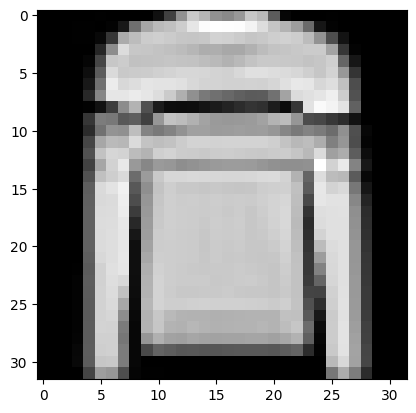

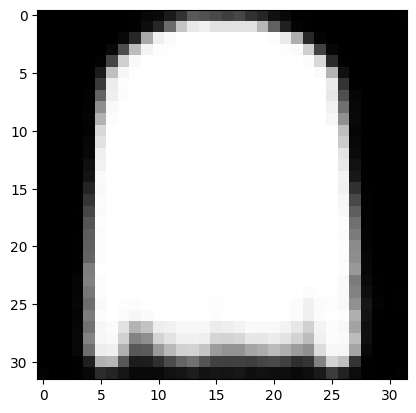

In [71]:

i = 5
x, y = next(iter(trainloader))
outputs = decoder(encoder(x.to(device)))
plt.imshow(x.numpy()[i][0], cmap='gray')
plt.show()
plt.imshow(outputs.cpu().detach().numpy()[i][0], cmap='gray')